# Prediction of Stock Price Direction
source: https://platform.stratascratch.com/data-projects/prediction-stock-price-direction

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, ConciseDateFormatter
from matplotlib.ticker import MultipleLocator

ImportError: cannot import name 'AutomDateFormatter' from 'matplotlib.dates' (c:\Users\Jerry_Dell_7060\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\dates.py)

In [3]:
train = pd.read_csv("./datasets/AMZN_train.csv")
val = pd.read_csv("./datasets/AMZN_val.csv")
test = pd.read_csv("./datasets/AMZN_test.csv")

In [56]:
train.info()
val.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4781 entries, 0 to 4780
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4781 non-null   datetime64[ns]
 1   Open       4781 non-null   float64       
 2   High       4781 non-null   float64       
 3   Low        4781 non-null   float64       
 4   Close      4781 non-null   float64       
 5   Adj Close  4781 non-null   float64       
 6   Volume     4781 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 261.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       503 non-null    datetime64[ns]
 1   Open       503 non-null    float64       
 2   High       503 non-null    float64       
 3   Low        503 non-null    float64       
 4   Close    

In [65]:
def longest_streak_of_ones(arr):
    """
    Given a numpy array of 0s and 1s, return the length of the longest consecutive run of 1s.
    """
    max_streak = 0
    current_streak = 0
    for val in arr:
        if val == 1:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    return max_streak

In [ ]:
def dataCleansing(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values("Date", inplace=True)
    df["direction"] = np.where(df["Adj Close"] > df["Adj Close"].shift(1), 1, 0)
    df["hi_low_gap_1d"] = df["High"].shift(1).max() / df["Low"].shift(1).min()
    df["hi_low_gap_3d"] = (
        df["High"].shift(1).rolling(3).max() / df["Low"].shift(1).rolling(3).min()
    )
    df["hi_low_gap_7d"] = (
        df["High"].shift(1).rolling(7).max() / df["Low"].shift(1).rolling(7).min()
    )
    df["hi_low_gap_14d"] = (
        df["High"].shift(1).rolling(14).max() / df["Low"].shift(1).rolling(14).min()
    )

    return df


train = dataCleansing(train)
val = dataCleansing(val)
test = dataCleansing(test)

In [64]:
train.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,direction,hi_low_gap_1d,hi_low_gap_3d,hi_low_gap_7d,hi_low_gap_14d
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,0,NaN,NaN,NaN,NaN
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,0,1.297298,NaN,NaN,NaN
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,0,1.158537,NaN,NaN,NaN
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,0,1.089743,1.538462,NaN,NaN
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,0,1.070063,1.217949,NaN,NaN
5,1997-05-22,1.437500,1.447917,1.312500,1.395833,1.395833,11776800,0,1.196969,1.287879,NaN,NaN
6,1997-05-23,1.406250,1.520833,1.333333,1.500000,1.500000,15937200,1,1.103175,1.333333,NaN,NaN
7,1997-05-27,1.510417,1.645833,1.458333,1.583333,1.583333,8697600,1,1.140625,1.253968,1.904762,NaN
8,1997-05-28,1.625000,1.635417,1.531250,1.531250,1.531250,4574400,0,1.128571,1.253968,1.507937,NaN
9,1997-05-29,1.541667,1.541667,1.479167,1.505208,1.505208,3472800,0,1.068027,1.234375,1.349206,NaN


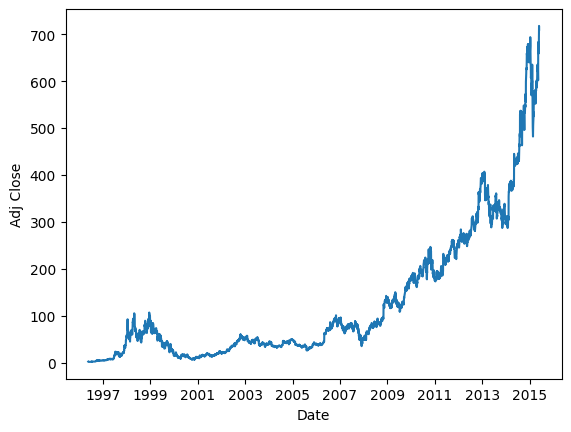

In [55]:
sns.lineplot(x="Date", y="Adj Close", data=train)

plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(MultipleLocator(365 * 2))